#

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function

In [2]:
import pickle as pkl
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [9]:
def numpy_fillna(data):
    # Get lengths of each row of data
    lens = np.array([len(i) for i in data])

    # Mask of valid places in each row
    mask = np.arange(lens.max()) < lens[:,None]

    # Setup output array and put elements from data into masked positions
    out = np.empty(mask.shape)
    out[:] = np.nan
    out[mask] = np.concatenate(np.array(data))
    return out

In [10]:
def generate_mean_std(stats):
    """
    stats ia dictionary of:
    keys : parameters being varied
    values:
    """
    out = {}
    for param in stats.keys():
        # Iterate each parameter to generate stats for each and every epoch:
        data = stats[param]
        out[param] = {}
        for _param in data.keys():
            # this corresponds to the val_err/val_acc/train_acc/train_err:
            _data = data[_param] # This data is for each trial!
            _data_paded = numpy_fillna(_data)
            mean = np.nanmean(_data_paded, axis=0)
            std = np.nanstd(_data_paded, axis=0)
            out[param][_param] = {'mean': mean,
                                  'std' : std}
    return out

In [11]:
def analyse_mean_std(data):
    """
    Find the best mean
    """
    best_epochs = {}
    for i in data.keys():
        # each parameter's validation and training result
        _data = data[i]
        # plot the accuracy for each layer
        _tr_acc = _data['train_acc']
        _tr_err = _data['train_err']
        _val_acc = _data['val_acc']
        _val_err = _data['val_err']
        _test_acc = _data['test_acc']
        best_epoch = np.argmax(_val_acc['mean'])
        best_epochs[i] = {'idx': best_epoch,
                       'mean': _val_acc['mean'][best_epoch],
                       'std':  _val_acc['std'][best_epoch],
                         'test_acc_mean': _test_acc['mean'][best_epoch],
                         'test_acc_std': _test_acc['std'][best_epoch]}
    return best_epochs

In [15]:
def plot_graph_mean_std(data, best_epochs):
    c = ['b','g','c','r','k','y','m']
    c_i=0
    fig1 = plt.figure(figsize=(10, 5))  # ERRROR
    ax11 = fig1.add_subplot(121)
    ax12 = fig1.add_subplot(122)
    fig2 = plt.figure(figsize=(10, 5))  # ACCURACY
    ax21 = fig2.add_subplot(121)
    ax22 = fig2.add_subplot(122)
    for i in data.keys():
        # plot each data dataset's validation and train
        _data = data[i]
        # plot the accuracy for each layer
        _tr_acc = _data['train_acc']
        _tr_err = _data['train_err']
        _val_acc = _data['val_acc']
        _val_err = _data['val_err']
        _x = np.arange(0, len(_tr_err['mean']))
        ax11.set_xlabel('epoch')
        ax11.set_ylabel('training error')
        ax11.plot(_x, _tr_err['mean'], label=i, c=c[c_i])
        ax11.fill_between(
            _x,
            _tr_err['mean'] - _tr_err['std'],
            _tr_err['mean'] + _tr_err['std'],
            alpha=.3, color=c[c_i])
        ax12.set_ylabel('validation error')
        ax12.set_xlabel('epoch')
        ax12.plot(
            _x, _val_err['mean'], label=i, color=c[c_i])
        ax12.fill_between(
            _x,
            _val_err['mean'] - _val_err['std'],
            _val_err['mean'] + _val_err['std'],
            alpha=.3, color=c[c_i])

        ax21.set_xlabel('epoch')
        ax21.set_ylabel('training accuracy')
        ax21.plot(_x, _tr_acc['mean'], label=i, c=c[c_i])
        ax21.fill_between(
            _x,
            _tr_acc['mean'] - _tr_acc['std'],
            _tr_acc['mean'] + _tr_acc['std'],
            alpha=.3, color=c[c_i])
        ax22.set_ylabel('validation accuracy')
        ax22.set_xlabel('epoch')
        ax22.plot(_x, _val_acc['mean'], label=i, c=c[c_i])
        ax22.fill_between(
            _x,
            _val_acc['mean'] - _val_acc['std'],
            _val_acc['mean'] + _val_acc['std'],
            alpha=.3, color=c[c_i])
        
        ax11.set_title('TRAINING')
        ax12.set_title('VALIDATION')
        ax12.legend(loc=0)
        ax22.legend(loc=0)
        
        ax22.scatter(best_epochs[i]['idx'], best_epochs[i]['mean'], c=c[c_i], marker='X')
        c_i+=1
        
    return fig1, fig2, ax11, ax12, ax21, ax22

## Experiment: Number of hidden units

In [5]:
expt_data = {}
expt_data[0] = pkl.load(open('./NumHiddenUnitsExpt/experiment_units_elu.pkl', 'rb'))

for i in range(1,4):
    name = './NumHiddenUnitsExpt/experiment_units_elu{}.pkl'.format(i)
    expt_data[i] = pkl.load(open(name, 'rb'))

expt_data[0] # this is the full run!

In [6]:
def plot_combined_layers(data):
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    for (layer, output) in data.items():
        keys = output[1]
        stats = output[0]
        # plot the accuracy for each layer
        ax1.plot(
            np.arange(1, stats.shape[0]),
            stats[1:, keys['error(valid)']])
        ax2.plot(
            np.arange(1, stats.shape[0]),
            stats[1:, keys['acc(valid)']], 
            label=layer)

    ax2.legend(loc='best');
    ax1.set_ylabel('validation error')
    ax2.set_ylabel('validation accuracy')
    ax2.set_xlabel('epoch number')

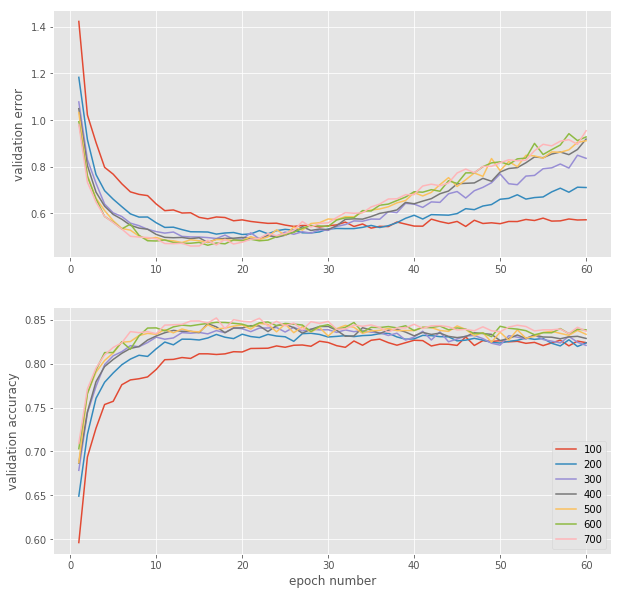

In [7]:
plot_combined_layers(expt_data[0])

In [8]:
hidden_units = [100,200,300,400,500,600,700]
hidden_units_stats = {a:dict() for a in hidden_units}
    
# Iterate through each of the test stats:
for i in range(1,4):
    _expt_data = expt_data[i]
    
    # Iterate through each hidden layer experiment:
    for num_units in _expt_data.keys():
        stats, keys, run_time, best_epoch = expt_data[i][num_units]
        if i == 1:
            hidden_units_stats[num_units]['val_err'] = []
            hidden_units_stats[num_units]['val_acc'] = []
            hidden_units_stats[num_units]['train_err'] = []
            hidden_units_stats[num_units]['train_acc'] = []
            hidden_units_stats[num_units]['test_acc'] = []
        hidden_units_stats[num_units]['val_err'].append(stats[1:, keys['error(valid)']])
        hidden_units_stats[num_units]['val_acc'].append(stats[1:, keys['acc(valid)']])
        hidden_units_stats[num_units]['train_err'].append(stats[1:, keys['error(train)']])
        hidden_units_stats[num_units]['train_acc'].append(stats[1:, keys['acc(train)']])
        hidden_units_stats[num_units]['test_acc'].append(stats[1:, keys['acc(test)']])

In [12]:
hidden_units_stats_mu_rho = generate_mean_std(hidden_units_stats)

In [13]:
best_epochs = analyse_mean_std(hidden_units_stats_mu_rho)

In [14]:
best_epochs

{100: {'idx': 36,
  'mean': 0.81749999999999967,
  'std': 0.0014873417721517068,
  'test_acc_mean': 0.80803797468354421,
  'test_acc_std': 0.0027215189873416312},
 200: {'idx': 12,
  'mean': 0.82267932489451467,
  'std': 0.0026397455391758344,
  'test_acc_mean': 0.81196202531645556,
  'test_acc_std': 0.00193633652414905},
 300: {'idx': 19,
  'mean': 0.83265822784810128,
  'std': 0.0,
  'test_acc_mean': 0.82069620253164566,
  'test_acc_std': 0.0},
 400: {'idx': 10,
  'mean': 0.8320675105485229,
  'std': 0.0034840160933913805,
  'test_acc_mean': 0.82130801687763677,
  'test_acc_std': 0.0037108019478002663},
 500: {'idx': 13,
  'mean': 0.83253164556962034,
  'std': 0.0,
  'test_acc_mean': 0.81917721518987341,
  'test_acc_std': 0.0},
 600: {'idx': 7,
  'mean': 0.83312236286919827,
  'std': 0.0059946061080775352,
  'test_acc_mean': 0.82405063291139224,
  'test_acc_std': 0.0035936884978680717},
 700: {'idx': 6,
  'mean': 0.83523206751054835,
  'std': 0.005391358363315688,
  'test_acc_mean': 

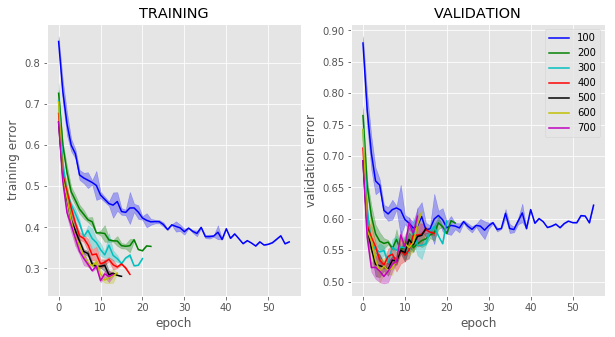

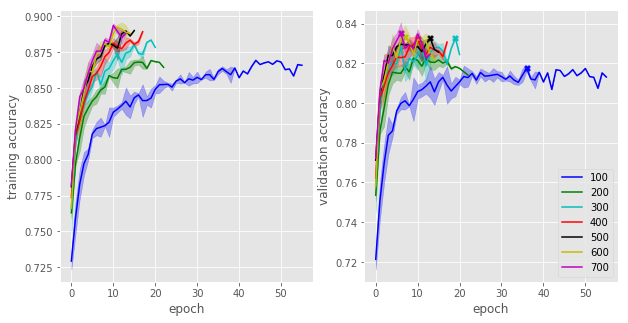

In [16]:
fig1,fig2, ax11,ax12,ax21,ax22 = plot_graph_mean_std(hidden_units_stats_mu_rho, best_epochs)

## Varying number of layers (for different activation function)

Hypothesis 1: There is a difference in validation accuracy when the number of hidden layers increases from 2 to 10.

Hypothesis 2: For the same number of layers, different activation functions will vary the results.



***Experiment Parameters:***
    
    Number of trials: range(1,4)
    layers_depth = [1,3,5,7]
    funcs = {'sigmoid':SigmoidLayer(), 
             'relu':ReluLayer(), 
             'elu':ELULayer(), 
             'selu':SELULayer()}
    num_epochs = 60
    num_hidden_unit = 100
    SGD(learningrule =  0.01)
    Early stopping = NO
    

In [17]:
fullElu = pkl.load(open("01_02_ActFunc_Layers/experiment_layers_elu.pkl", 'rb'))

In [28]:
fullSelu =  pkl.load(open("01_02_ActFunc_Layers/experiment_layers_selu.pkl", 'rb'))

In [29]:
fullRelu = pkl.load(open("01_02_ActFunc_Layers/experiment_layers_relu.pkl", 'rb'))

In [30]:
fullSigmoid = pkl.load(open("01_02_ActFunc_Layers/experiment_layers_sigmoid.pkl", 'rb'))

In [24]:
elu1.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10])

In [25]:
model, stats, keys, run_time = pkl.load(open("01_02_ActFunc_Layers/actfunc_expt_t0_d1_relu.pkl", 'rb'))

In [ ]:
sigmoid = {}
relu = {}
elu = {}
selu = {}
layers_depth = [1, 3, 5, 7]  # +1 to each for the total number of layers:

for func, store in {'relu':relu, 'elu':elu, 'sigmoid':sigmoid, 'selu':selu}.items():
    for layers in layers_depth:
        for trials in range(2):
            model, stats, keys, run_time = pkl.load(
                open("01_02_ActFunc_Layers/actfunc_expt_t{}_d{}_{}.pkl".format(
                    trials, layers, func), 'rb'))
            store[layers][t]